In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [4]:
X = pd.DataFrame(housing.data,columns=housing.feature_names)

In [5]:
X.isnull().any()

MedInc        False
HouseAge      False
AveRooms      False
AveBedrms     False
Population    False
AveOccup      False
Latitude      False
Longitude     False
dtype: bool

In [6]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
y = housing.target

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
import xgboost as xgb

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(seed=123,objective="reg:squarederror",n_estimators=10)

# Fit the regressor to the training set
xg_reg.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.544916


In [13]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 0.935129


# Using regularization in XGBoost

In [14]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    
    # Pass this updated param dictionary into cv
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, 
                  nfold=2, num_boost_round=5, 
                  metrics="rmse", as_pandas=True, seed=123)
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2      rmse
0    1  0.778195
1   10  0.783919
2  100  0.822457


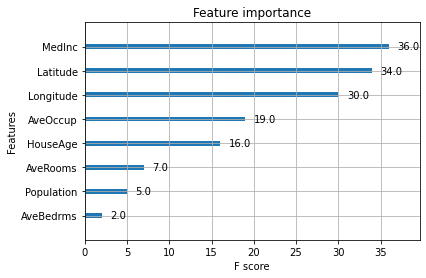

In [15]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective": "reg:squarederror", "max_depth": 4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params,dtrain=housing_dmatrix,num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

In [17]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, early_stopping_rounds=10,num_boost_round=50,as_pandas=True,params=params,metrics='rmse',nfold=3,seed=123)

# Print cv_results
print(cv_results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          1.462828        0.005529        1.465340       0.011217
1          1.143124        0.004570        1.150055       0.009816
2          0.939146        0.003773        0.948381       0.007460
3          0.808610        0.004855        0.821553       0.007730
4          0.725585        0.006141        0.739874       0.005441
5          0.671414        0.004638        0.688221       0.005762
6          0.633774        0.003228        0.650904       0.008133
7          0.606048        0.008341        0.624120       0.008888
8          0.586223        0.008837        0.605857       0.006527
9          0.568964        0.005324        0.589065       0.011413
10         0.555295        0.002455        0.576495       0.008162
11         0.546593        0.002349        0.570481       0.009861
12         0.540629        0.001898        0.566814       0.011006
13         0.528651        0.003696        0.555914       0.00

In [21]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params,seed=123, num_boost_round=10, nfold=3,
                        early_stopping_rounds=5,metrics='rmse',as_pandas= True)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

     eta  best_rmse
0  0.001   1.931078
1  0.010   1.793167
2  0.100   0.974117


In [23]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params = {"objective":"reg:squarederror"}

# Create list of max_depth values
max_depths = [2,5,10,20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = cv_results = xgb.cv(dtrain=housing_dmatrix,params=params,seed=123,num_boost_round=10, nfold=2,early_stopping_rounds=5,metrics='rmse',as_pandas= True)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

   max_depth  best_rmse
0          2   0.696379
1          5   0.562416
2         10   0.541528
3         20   0.565039


In [26]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:squarederror","max_depth":3}

# Create list of hyperparameter values: colsample_bytree_vals
colsample_bytree_vals = [0.1,0.5,0.8,1]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params['colsample_bytree'] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

   colsample_bytree  best_rmse
0               0.1   0.830244
1               0.5   0.659547
2               0.8   0.627300
3               1.0   0.623250


# Grid search with XGBoost

In [32]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator = gbm,
    param_grid = gbm_param_grid, scoring = "neg_mean_squared_error", cv=4, verbose =1)


# Fit grid_mse to the data
grid_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found:  0.706204362480588


In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator =gbm,
    param_distributions =gbm_param_grid,
    scoring="neg_mean_squared_error",
    cv=4,
    verbose=1,
    n_iter=5)


# Fit randomized_mse to the data
randomized_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 25, 'max_depth': 7}
Lowest RMSE found:  0.6747220247596593
